# Banking dataset with a `pymc` model

<div class="alert alert-warning">

Warning

We are still refining the difference in differences analysis code. Expect improvements soon.

</div>

This notebook analyses historic data on banking closures from [Richardson & Troost (2009)](http://masteringmetrics.com/wp-content/uploads/2015/02/Richardson_Troost_2009_JPE.pdf) and used as a case study for a difference in differences analysis in the [Mastering Metrics](http://www.masteringmetrics.com) book. Here, we replicate this analysis, but using Bayesian inference.

In [1]:
import arviz as az
import causalpy as cp

In [2]:
# %config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Load data

The raw dataset has a `date` columns which is just some uninterpretable number. All we need for our analysis is the `year` column. We also have columns `bib6`, `bio6`, `bib8`, `bio8`. We know that the `6` and `8` represent the 6th and 8th Federal Reserve districts, respectively. I assume `bib` means "banks in business", so I'll discard the `bib*` columns. The data is at daily resolution, but we will convert this to yearly resolution. And from what I can tell from Figure 5.2 of the [Mastering Metrics](http://www.masteringmetrics.com) book, they seem to present the _median_ number of banks open per year. Let's load the data up and do those steps.

In [4]:
df = (
    cp.load_data("banks")
    # just keep columns we want
    .filter(items=["bib6", "bib8", "year"])
    # rename to meaningful variables
    .rename(columns={"bib6": "Sixth District", "bib8": "Eighth District"})
    # reduce from daily resolution to examine median banks open by year
    .groupby("year").median()
)

Let's visualise what we have. This matches up exactly with Figure 5.2 of the [Mastering Metrics](http://www.masteringmetrics.com) book.

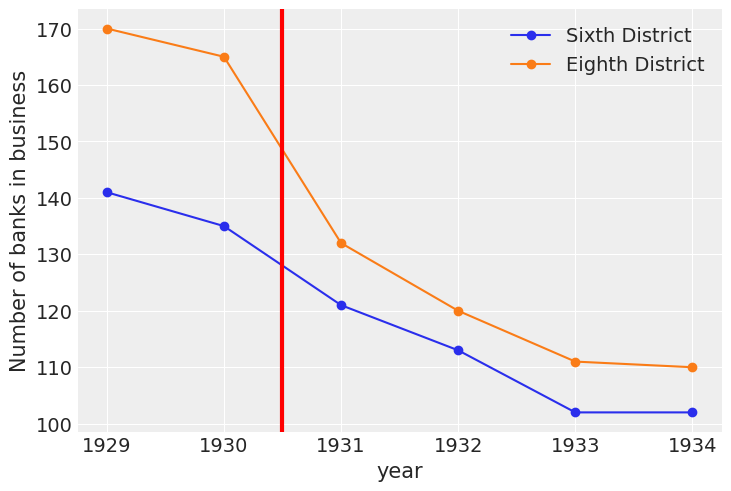

In [5]:
ax = df[["Sixth District", "Eighth District"]].plot(style="o-")
ax.set(ylabel="Number of banks in business")
ax.axvline(x=1930.5, c="r", lw=3, label="intervention");

Just a few more a final processing steps to make the data amenable to analysis. We will convert from wide form into long form. Then we will add a new column `treated` which indicates the observations where treatment has taken place.

In [6]:
import pandas as pd

df.reset_index(level=0, inplace=True)
df_long = pd.melt(
    df,
    id_vars=["year"],
    value_vars=["Sixth District", "Eighth District"],
    var_name="district",
    value_name="bib",
).sort_values("year")

# ensure district is coded as a categorical variable
# TODO: check if we need to do this OR specify `C(district)` in the model formula
df_long["district"] = df_long["district"].astype("category")

# We also need to create a column called `unit` which labels each distinct unit. In our case we just have two treatment units (each district). So we can build a `unit` column from `district`.
df_long["unit"] = df_long["district"]

# We also need to create a `treated` column to define which observations recieved the treatment
df_long["treated"] = (df_long.year >= 1931) & (df_long.district == "Sixth District")
df_long

,year,district,bib,unit,treated
0,1929,Sixth District,141.0,Sixth District,False
6,1929,Eighth District,170.0,Eighth District,False
1,1930,Sixth District,135.0,Sixth District,False
7,1930,Eighth District,165.0,Eighth District,False
2,1931,Sixth District,121.0,Sixth District,True
8,1931,Eighth District,132.0,Eighth District,False
3,1932,Sixth District,113.0,Sixth District,True
9,1932,Eighth District,120.0,Eighth District,False
4,1933,Sixth District,102.0,Sixth District,True
10,1933,Eighth District,111.0,Eighth District,False


## Analysis 1

First we'll do an analysis just looking at data from 1930 and 1931. This way we just have a single pre-intervention and a single post-intervention measurement.

In [7]:
result = cp.pymc_experiments.DifferenceInDifferences(
    df_long[df_long.year.isin([1930, 1931])],
    formula="bib ~ 1 + district + year + district:treated",
    time_variable_name="year",
    group_variable_name="district",
    treated="Sixth District",
    untreated="Eighth District",
    prediction_model=cp.pymc_models.LinearRegression(),
)


# from causalpy.pymc_experiments import DifferenceInDifferences
# from causalpy.pymc_models import LinearRegression

# result = DifferenceInDifferences(
#     df_long[df_long.year.isin([1930, 1931])],
#     formula="bib ~ 1 + district + year + district:treated",
#     time_variable_name="year",
#     group_variable_name="district",
#     treated="Sixth District",
#     untreated="Eighth District",
#     prediction_model=LinearRegression(),
# )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


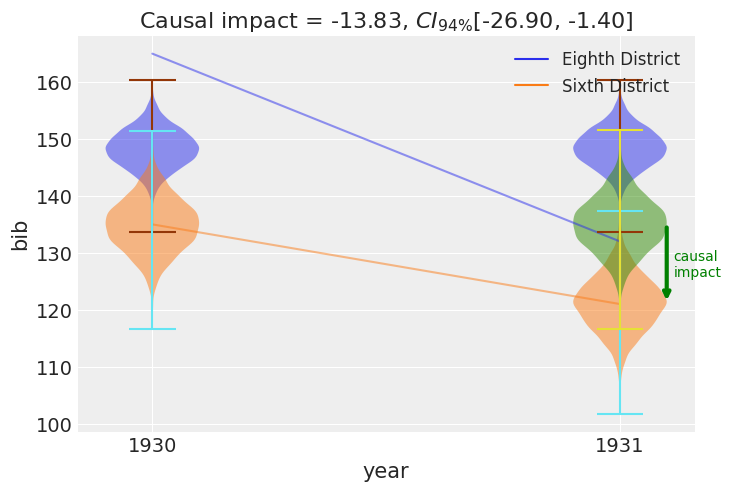

In [8]:
fig, ax = result.plot()

In [9]:
result.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + district + year + district:treated

Results:
Causal impact = -13.83, $CI_{94\%}$[-26.90, -1.40]
Model coefficients:
  Intercept                     1.06, 94% HDI [-91.52, 93.47]
  district[T.Sixth District]    -13.51, 94% HDI [-24.71, -2.26]
  district[Eighth District]:treated[T.True]-0.61, 94% HDI [-89.52, 87.13]
  district[Sixth District]:treated[T.True]-13.83, 94% HDI [-26.90, -1.40]
  year                          0.08, 94% HDI [0.03, 0.12]
  sigma                         4.87, 94% HDI [4.01, 5.89]


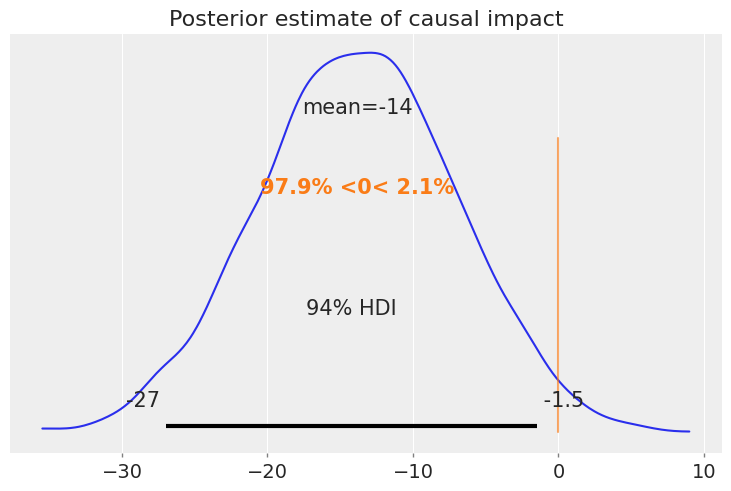

In [10]:
ax = az.plot_posterior(result.causal_impact, ref_val=0)
ax.set(title="Posterior estimate of causal impact");

## Analysis 2

Now we'll do a difference in differences analysis of the full dataset.

<div class="alert alert-info">

Note

Coming soon!

</div>